In [1]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
from itertools import zip_longest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import shap

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from util import ticker_option, combine_dfs, get_stock_price, prepare_ml_dataset, concatenate_strings

In [4]:
price_dict = {}

In [5]:
# price_dict

In [6]:
# top 5 tickers
ticker_list = [
    "MSFT", "AAPL", "NVDA", "AMZN", "META", "GOOGL", "GOOG", "BRK.B", "LLY", "AVGO", "JPM", 
    "XOM", "TSLA", "UNH", "V", "PG", "MA", "COST", "JNJ", "HD", "MRK",
]
df = combine_dfs(ticker_list, price_dict)
df

MSFT
AAPL
NVDA
AMZN
META
GOOGL
GOOG
BRK.B
No options found for BRK.B
LLY
AVGO
JPM
XOM
TSLA
UNH
V
PG
MA
COST
JNJ
HD
MRK


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,exp,days_to_exp,stockPrice,option_ticker
0,AMZN240621P01540000,2022-04-27,1540.0,138.00,114.50,130.50,0.000000,0.000000,1.0,1.0,0.000010,True,REGULAR,USD,put,2024-06-21,785.21,138.17,AMZN
1,AMZN240621C01840000,2022-04-28,1840.0,1223.65,774.00,793.00,0.000000,0.000000,2.0,2.0,0.000000,False,REGULAR,USD,call,2024-06-21,784.43,144.60,AMZN
2,AMZN240621P01660000,2022-04-28,1660.0,84.30,145.00,161.00,0.000000,0.000000,3.0,2.0,0.000010,True,REGULAR,USD,put,2024-06-21,784.29,144.60,AMZN
3,AMZN240621C01640000,2022-04-29,1640.0,1114.45,904.00,922.00,0.000000,0.000000,2.0,2.0,0.000000,False,REGULAR,USD,call,2024-06-21,783.39,124.28,AMZN
4,AMZN240621C01740000,2022-04-29,1740.0,998.00,838.00,856.00,0.000000,0.000000,1.0,1.0,0.000000,False,REGULAR,USD,call,2024-06-21,783.18,124.28,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39971,GOOG250321P00160000,2024-05-31,160.0,9.55,8.15,9.85,1.350000,16.463419,2.0,432.0,0.266945,False,REGULAR,USD,put,2025-03-21,293.24,173.96,GOOG
39972,GOOG250321P00155000,2024-05-31,155.0,7.90,6.55,8.20,1.320000,20.060793,1.0,430.0,0.272071,False,REGULAR,USD,put,2025-03-21,293.22,173.96,GOOG
39973,GOOG250321P00150000,2024-05-31,150.0,6.56,5.50,7.15,1.140000,21.033209,1.0,348.0,0.285408,False,REGULAR,USD,put,2025-03-21,293.34,173.96,GOOG
39974,GOOG250620C00125000,2024-05-31,125.0,57.78,55.50,60.40,-3.040001,-4.998357,1.0,628.0,0.496648,True,REGULAR,USD,call,2025-06-20,384.19,173.96,GOOG


In [7]:
df =  prepare_ml_dataset(df)
df

,strike,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,days_to_exp,stockPrice,type_call,type_put,lastPrice
0,1540.0,0.000000,0.000000,1.0,1.0,0.000010,1,785.21,138.17,0,1,138.00
1,1840.0,0.000000,0.000000,2.0,2.0,0.000000,0,784.43,144.60,1,0,1223.65
2,1660.0,0.000000,0.000000,3.0,2.0,0.000010,1,784.29,144.60,0,1,84.30
3,1640.0,0.000000,0.000000,2.0,2.0,0.000000,0,783.39,124.28,1,0,1114.45
4,1740.0,0.000000,0.000000,1.0,1.0,0.000000,0,783.18,124.28,1,0,998.00
...,...,...,...,...,...,...,...,...,...,...,...,...
22270,85.0,1.399994,1.559013,1.0,48.0,0.608219,1,384.26,173.96,1,0,91.20
22271,220.0,-0.700001,-4.069772,6.0,10219.0,0.283714,0,594.40,192.25,1,0,16.50
22272,225.0,0.630000,4.214047,15.0,3220.0,0.277900,0,594.17,192.25,1,0,15.58
22273,125.0,-3.040001,-4.998357,1.0,628.0,0.496648,1,384.19,173.96,1,0,57.78


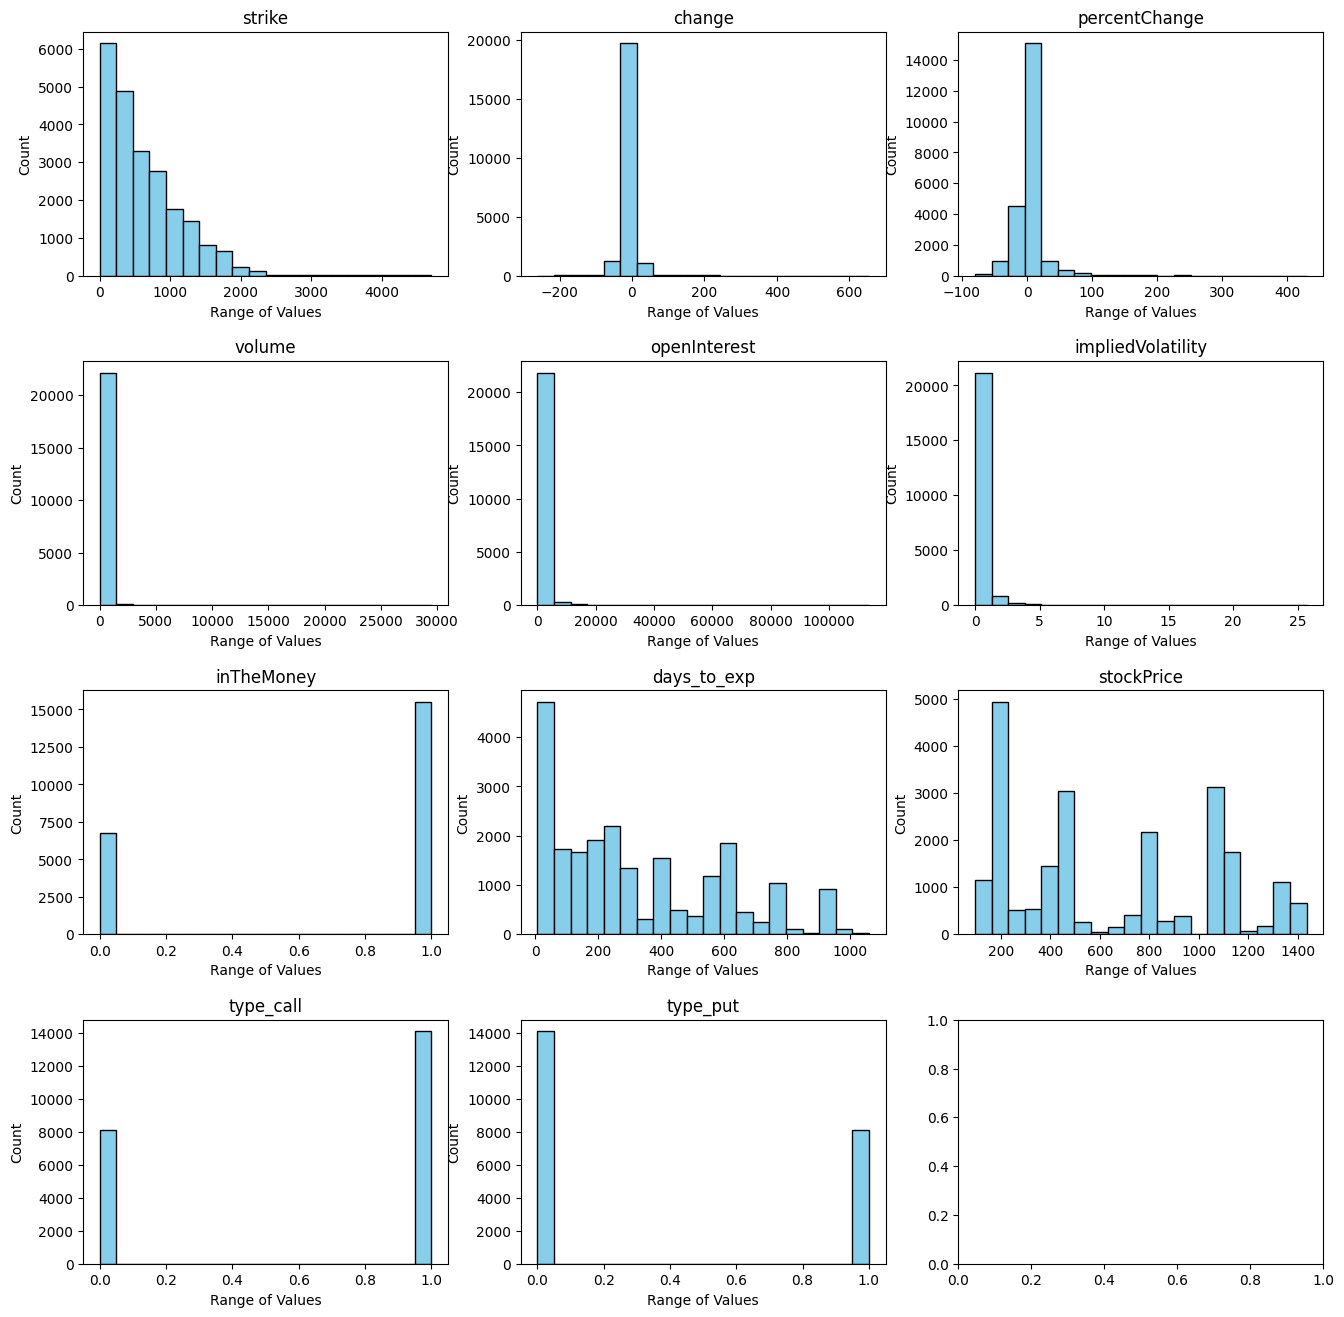

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(16, 16), gridspec_kw={'hspace': 0.35})

axes_flat = axes.flatten()

for ax, col in zip(axes_flat, df.iloc[:, :-1].columns):
    ax.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f"{col}")
    ax.set_xlabel('Range of Values')
    ax.set_ylabel('Count')

plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22275 entries, 0 to 22274
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   strike             22275 non-null  float64
 1   change             22275 non-null  float64
 2   percentChange      22275 non-null  float64
 3   volume             22275 non-null  float64
 4   openInterest       22275 non-null  float64
 5   impliedVolatility  22275 non-null  float64
 6   inTheMoney         22275 non-null  int32  
 7   days_to_exp        22275 non-null  float64
 8   stockPrice         22275 non-null  float64
 9   type_call          22275 non-null  int32  
 10  type_put           22275 non-null  int32  
 11  lastPrice          22275 non-null  float64
dtypes: float64(9), int32(3)
memory usage: 1.8 MB


In [10]:
df[df.isna().any(axis=1)]

,strike,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,days_to_exp,stockPrice,type_call,type_put,lastPrice


In [15]:
def train_model(df):
    # train test split
    X, y = df.iloc[:, :-1], df.iloc[:, -1:].to_numpy().ravel()
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, random_state=1337, test_size=0.25
    )

    # Gridsearch CV
    max_depth_range = [2, 3, 4]
    n_estimators_range = [200, 250]
    steps = [
        ('scaler', StandardScaler()),
        ('clf', None),
    ]
    pipe = Pipeline(steps)
    param_grid = [
        {
            'clf': [LinearRegression()], 
        },
        {
            'clf': [DecisionTreeRegressor()], 
            'clf__max_depth': max_depth_range
        },
        {
            'clf': [
                RandomForestRegressor(),
                GradientBoostingRegressor(),
            ], 
            'clf__max_depth': max_depth_range,
            'clf__n_estimators': n_estimators_range,
        }
    ]
    cv = 5
    scoring = make_scorer(r2_score)
    grid_search = GridSearchCV(
        pipe, param_grid, scoring=scoring,
        cv=cv, n_jobs=-1, return_train_score=True
    )
    grid_search.fit(X_trainval, y_trainval)

    print("bests:")
    print(grid_search.best_params_)
    print(grid_search.best_score_)

    cv_results = pd.DataFrame(grid_search.__dict__['cv_results_'])
    params = [i for i in cv_results.columns if "param_clf" in i]
    cv_results['idn'] = cv_results.apply(lambda row: concatenate_strings(row, params), axis=1)

    display(
        cv_results[['idn', 'params', 'mean_test_score']].sort_values(by=["mean_test_score"], ascending=False).reset_index(drop=True)
    )
    display(
        cv_results[(cv_results['params'] == grid_search.best_params_)][['idn', 'params', 'mean_test_score']].reset_index(drop=True)
    )

    best_estimator = grid_search.best_estimator_
    best_estimator.fit(X_trainval, y_trainval)

    holdout_preds = best_estimator.predict(X_test)
    print("model performance:")
    print(r2_score(y_test, holdout_preds))
    print(mean_absolute_error(y_test, holdout_preds))
    print(mean_squared_error(y_test, holdout_preds))

    display(
        pd.DataFrame({'Predict': holdout_preds, 'Actual': y_test})
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ("GradientBoostingClassifier", GradientBoostingRegressor(max_depth=4, n_estimators=200))
    ])
    pipeline.fit(X_trainval, y_trainval)
    holdout_preds = pipeline.predict(X_test)
    print(r2_score(y_test, holdout_preds))
    print(mean_absolute_error(y_test, holdout_preds))
    print(mean_squared_error(y_test, holdout_preds))
    bm = pipeline.named_steps['GradientBoostingClassifier']
    bm.fit(X_trainval, y_trainval)



    shap_explainer = shap.Explainer(
        pipeline.named_steps['GradientBoostingClassifier'], X_trainval, feature_names=X.columns
    )
    shap_values = shap_explainer(
        X_test, 
        check_additivity=False
    )

    print("shap summary plots")
    shap.summary_plot(shap_values, X_test, feature_names=X.columns)
    shap.summary_plot(shap_values, plot_type='bar', feature_names=X.columns)

    shap_explanation = shap.Explanation(shap_values.values[:, :],
                                    shap_values.base_values[0],
                                    shap_values.data,
                                    feature_names=X.columns)

    print("shap values vs. feature values")
    for i in X.columns:
        shap.plots.scatter(shap_explanation[:, i])    
    
    return X_test, y_test, shap_values, X, shap_explainer, bm

In [31]:
def view_shap_value_for_instance(X_test, shap_values, X, shape_explainer, bm, instance_index):
    # Choose an instance to explain (e.g., the first instance in the test set)
    display(X_test.iloc[[instance_index]])
    shap_value_instance = shap_values[instance_index]
    instance_data = X_test.iloc[instance_index]
    
    # Create the SHAP waterfall plot for the chosen instance
    shap.waterfall_plot(shap.Explanation(values=shap_value_instance, 
                                         base_values=shap_explainer.expected_value, 
                                         data=instance_data,
                                         feature_names=X.columns), max_display=100)
    
    
    
    print('predict')
    print(bm.predict(X_test.iloc[[instance_index]])[0])
    print('actual')
    print(y_test[instance_index])

    shap.force_plot(shap.Explanation(values=shap_value_instance, 
                                     base_values=shap_explainer.expected_value, 
                                     data=instance_data,
                                     feature_names=X.columns), matplotlib=True, figsize=(60, 5))

bests:
{'clf': GradientBoostingRegressor(), 'clf__max_depth': 4, 'clf__n_estimators': 250}
0.9675457448880532


,idn,params,mean_test_score
0,GradientBoostingRegressor()_4_250,"{'clf': GradientBoostingRegressor(), 'clf__max...",0.967546
1,GradientBoostingRegressor()_4_200,"{'clf': GradientBoostingRegressor(), 'clf__max...",0.963369
2,GradientBoostingRegressor()_3_250,"{'clf': GradientBoostingRegressor(), 'clf__max...",0.942857
3,GradientBoostingRegressor()_3_200,"{'clf': GradientBoostingRegressor(), 'clf__max...",0.936140
4,GradientBoostingRegressor()_2_250,"{'clf': GradientBoostingRegressor(), 'clf__max...",0.890531
5,GradientBoostingRegressor()_2_200,"{'clf': GradientBoostingRegressor(), 'clf__max...",0.882484
6,RandomForestRegressor()_4_200,"{'clf': RandomForestRegressor(), 'clf__max_dep...",0.766579
7,RandomForestRegressor()_4_250,"{'clf': RandomForestRegressor(), 'clf__max_dep...",0.766450
8,DecisionTreeRegressor()_4,"{'clf': DecisionTreeRegressor(), 'clf__max_dep...",0.719125
9,RandomForestRegressor()_3_200,"{'clf': RandomForestRegressor(), 'clf__max_dep...",0.668130


,idn,params,mean_test_score
0,GradientBoostingRegressor()_4_250,"{'clf': GradientBoostingRegressor(), 'clf__max...",0.967546


model performance:
0.9674222279374818
22.0256509590287
1478.6166145202112


,Predict,Actual
0,636.030043,650.93
1,150.622927,168.70
2,63.468224,68.35
3,249.674859,229.73
4,99.156223,106.00
...,...,...
5564,45.273171,35.00
5565,123.297498,125.16
5566,19.554715,13.34
5567,60.718071,44.36


0.9639445235350439
23.298289366831646
1636.4601742322343


 98%|===================| 5472/5569 [00:28<00:00]        

shap summary plots


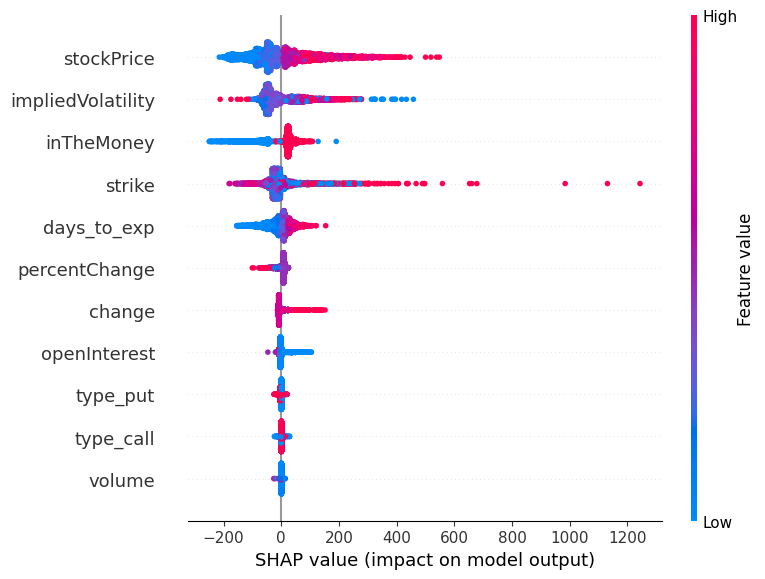

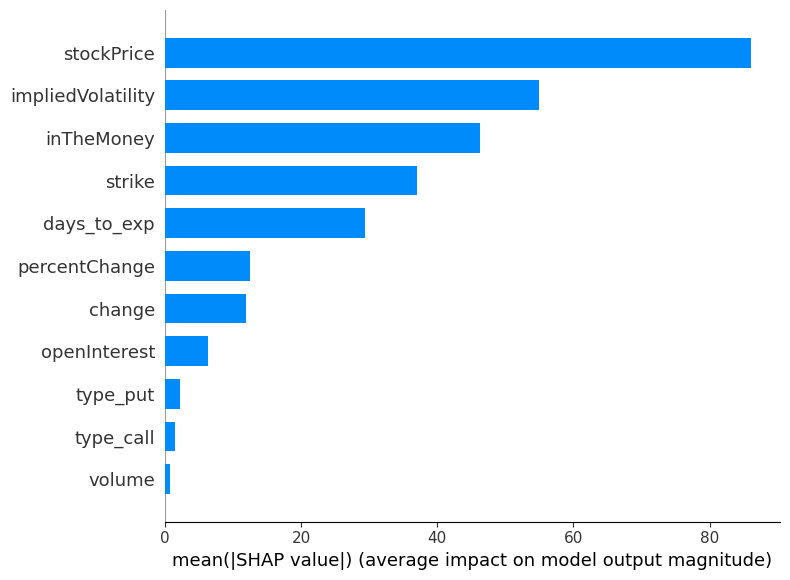

shap values vs. feature values


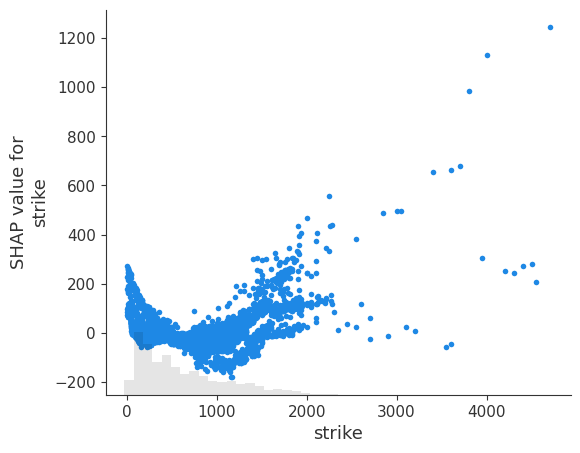

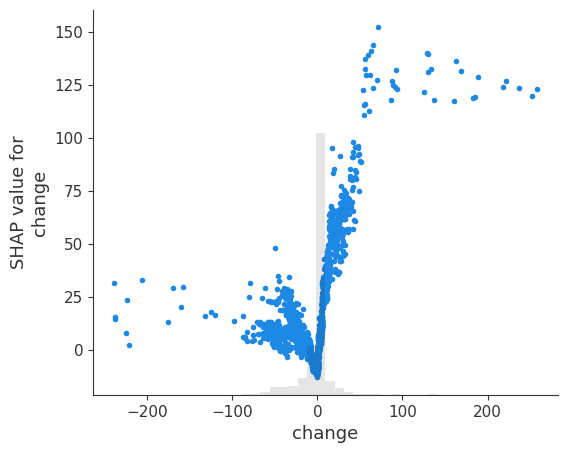

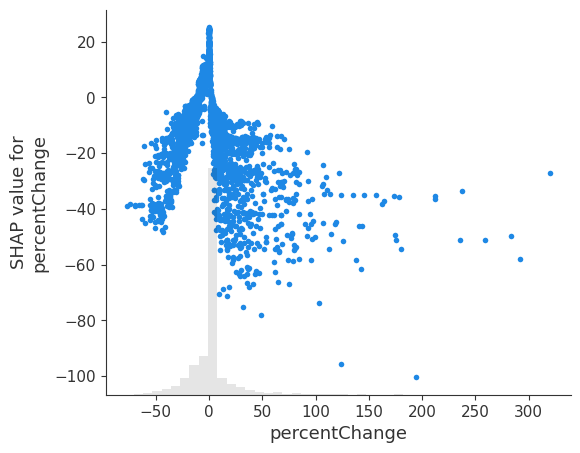

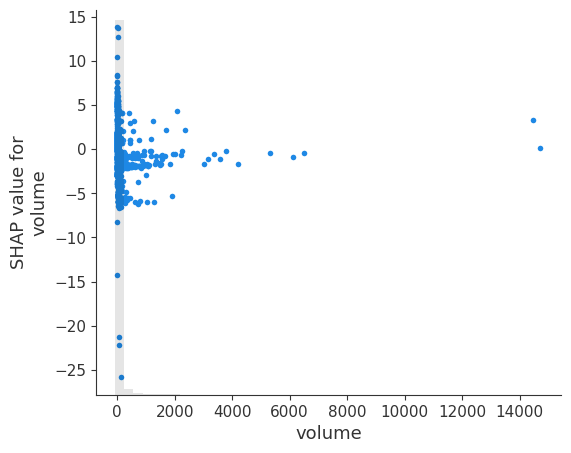

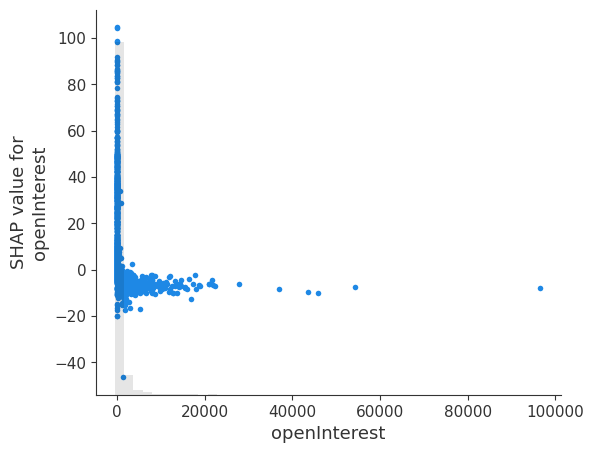

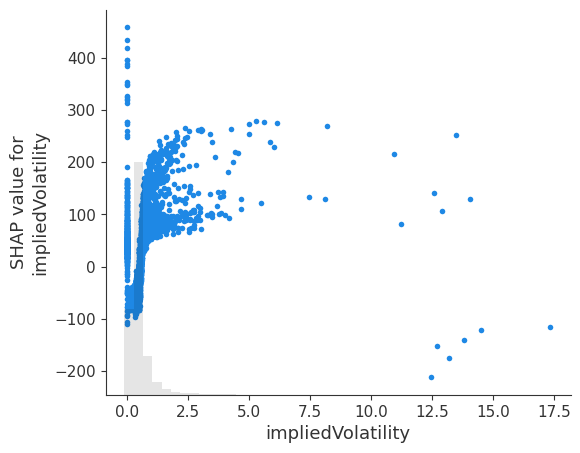

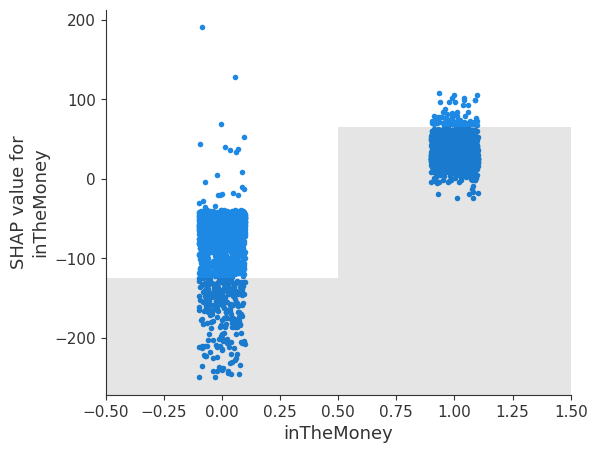

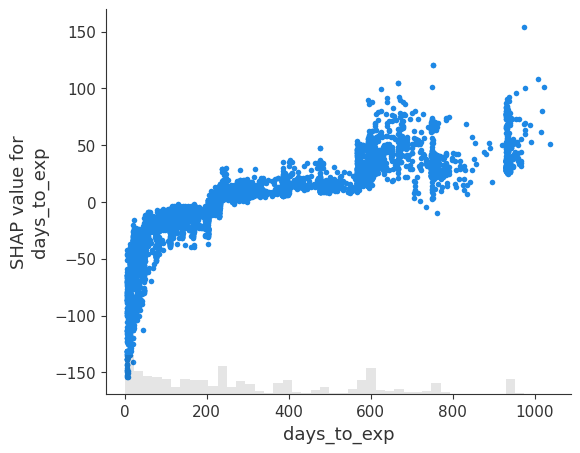

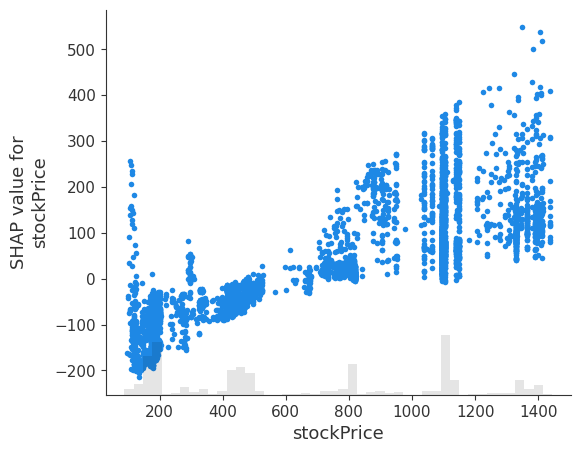

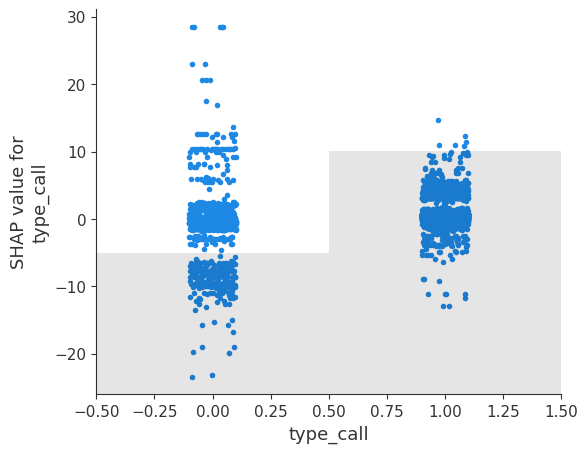

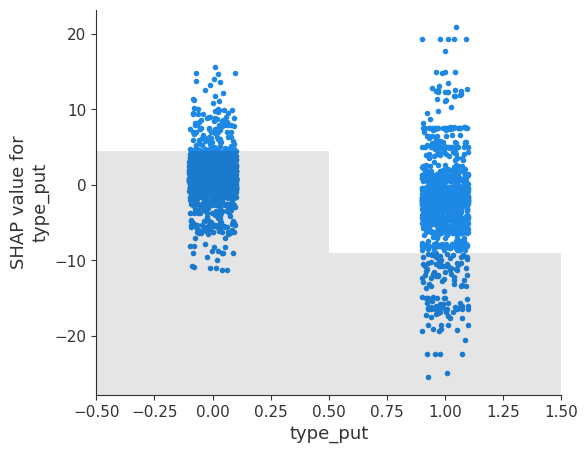

In [17]:
X_test, y_test, shap_values, X, shap_explainer, bm = train_model(df)

,strike,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,days_to_exp,stockPrice,type_call,type_put
12839,505.0,91.79999,16.418362,2.0,88.0,0.821077,1,203.39,1105.0,1,0


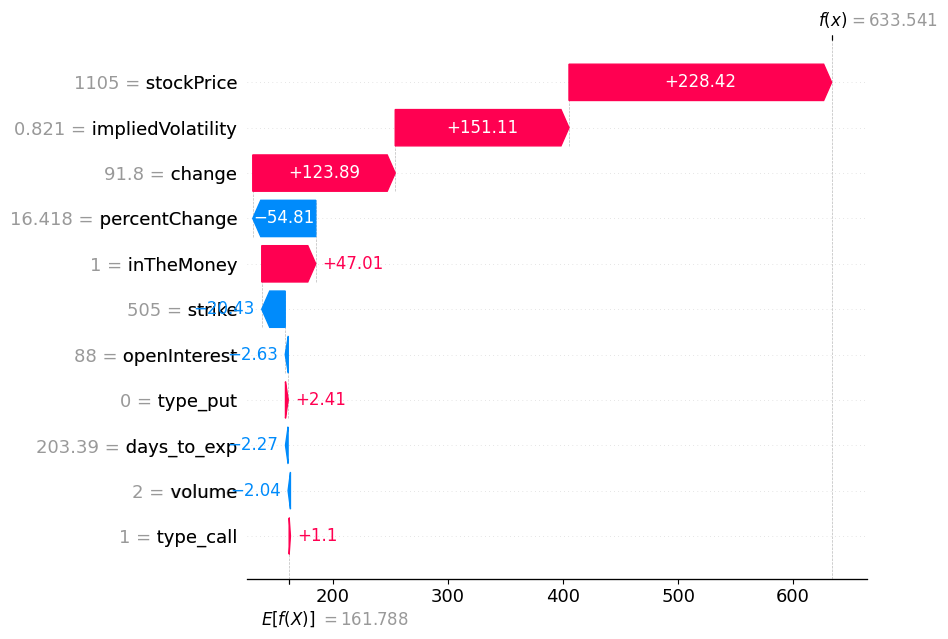

predict
633.5414390795202
actual
650.93


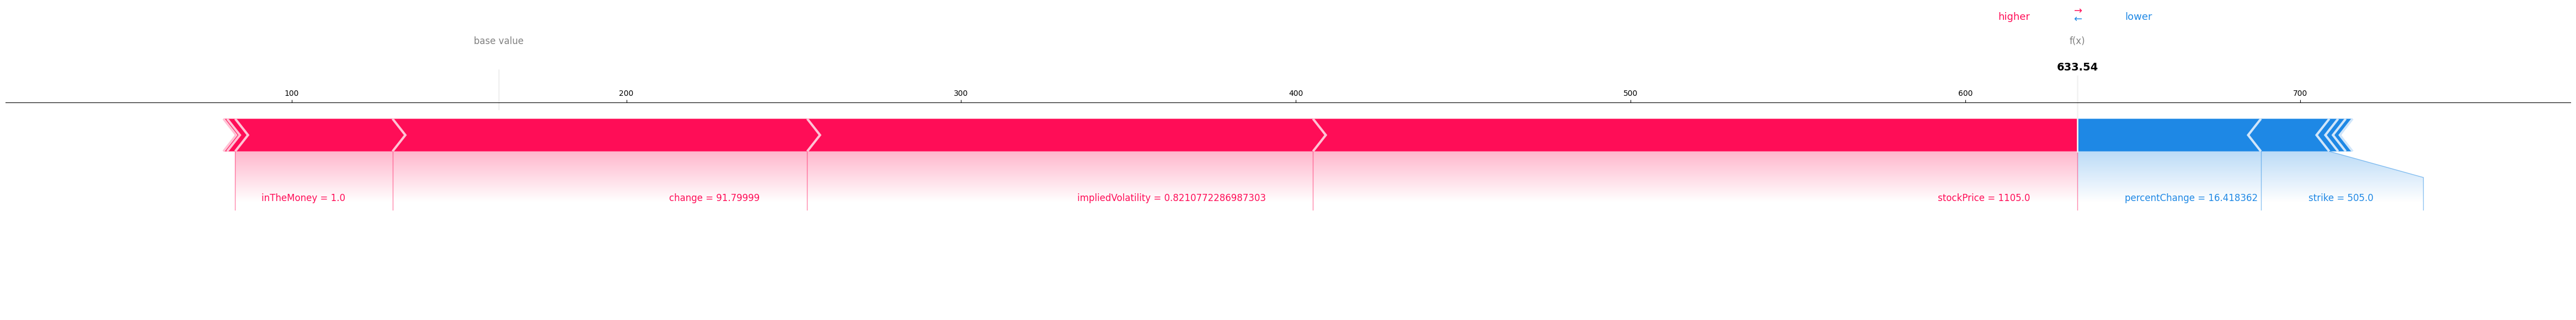

In [32]:
view_shap_value_for_instance(X_test, shap_values, X, shap_explainer, bm, 0)

,strike,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,days_to_exp,stockPrice,type_call,type_put
12944,1560.0,41.93,33.07565,20.0,50.0,0.521497,0,567.3,1105.0,1,0


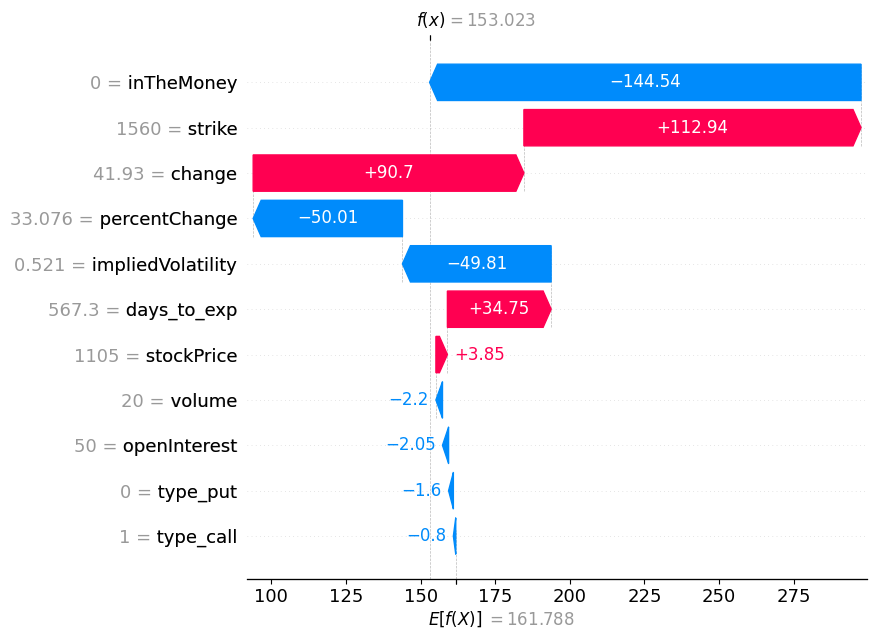

predict
153.02251786297975
actual
168.7


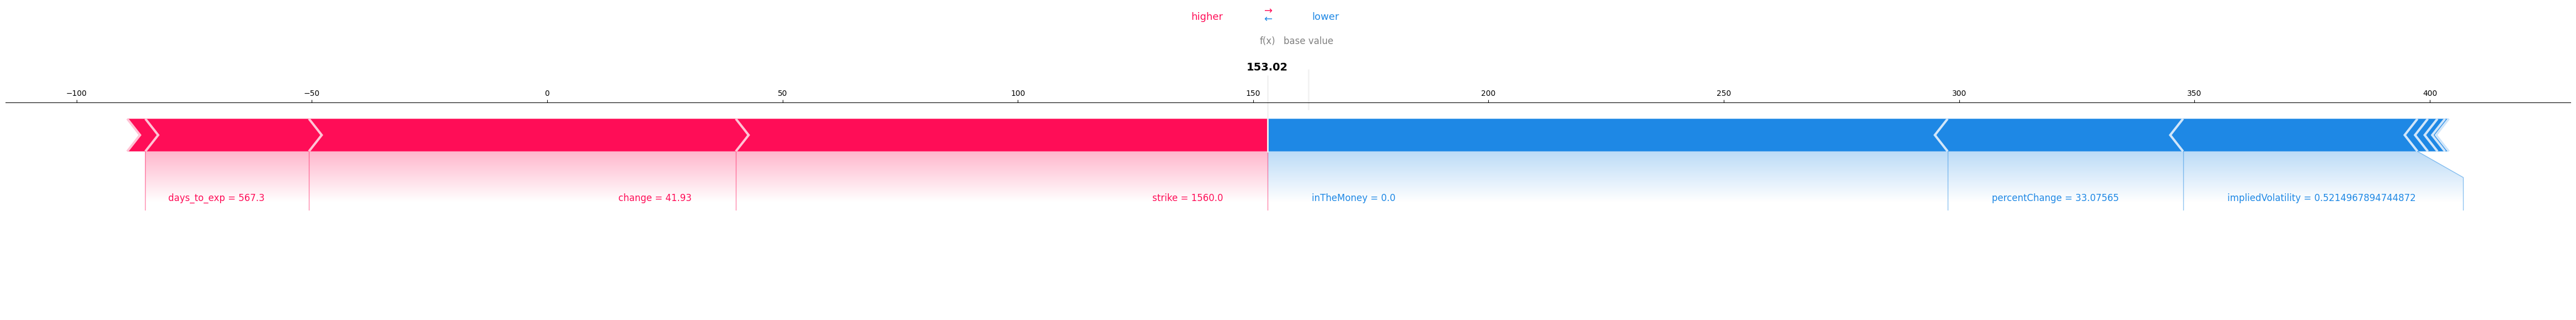

In [34]:
view_shap_value_for_instance(X_test, shap_values, X, shap_explainer, bm, 1)

,strike,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,days_to_exp,stockPrice,type_call,type_put
17565,400.0,-8.380005,-10.921419,27.0,3018.0,0.509404,1,20.17,466.83,1,0


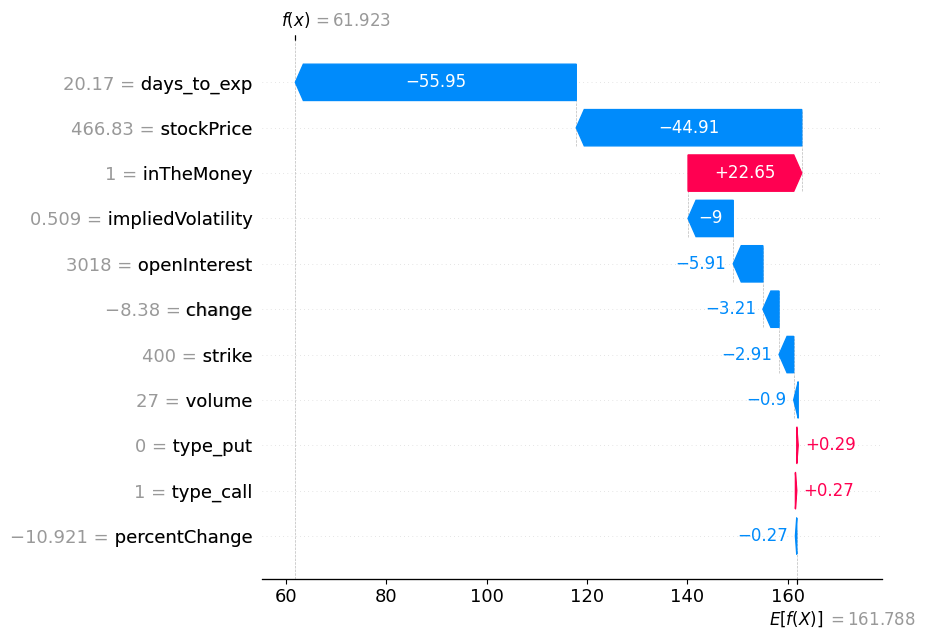

predict
61.92272361474817
actual
68.35


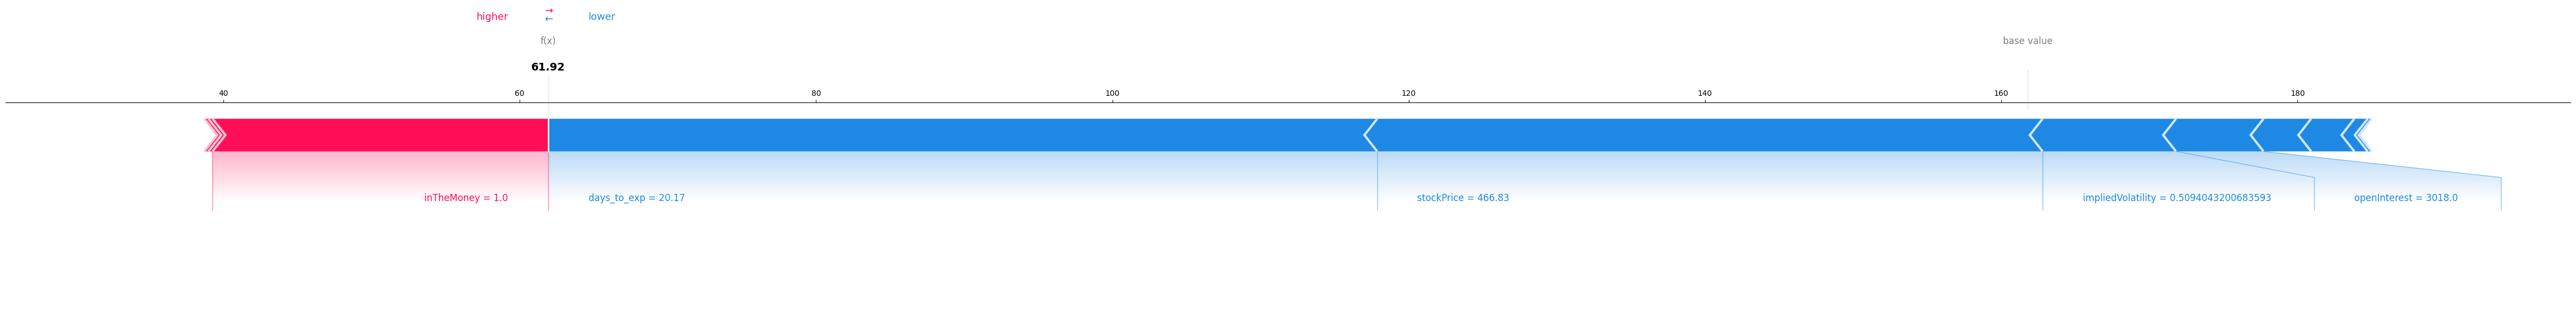

In [36]:
view_shap_value_for_instance(X_test, shap_values, X, shap_explainer, bm, 2)